# Lab 4: Unsupervised Learning

# Overview

In Lab 2, we learned how to use linear regression to study whether certain features are significant in explaining and predicting an observed outcome. In Lab 3, we applied ensemble methods to refine our predictions. In this notebook, we shift the focus from prediction to exploration. 

<b>Why focus on data exploration?</b>

The reality is that most available data in the world is unlabelled and needs to be understood before we can form a testable hypothesis and before it is suitable for predictive analyses.

That's where unsupervised learning comes in! Unsupervised learning methods are a set of techniques designed to <i>explore</i> the data rather than predict outcomes. There are many unsupervised learning methods (that you can learn more about how to use in Python <a href="http://scikit-learn.org/stable/unsupervised_learning.html">here</a>), but the most commonly-used method is cluster analysis (with greater theoretical detail described <a href="https://www-users.cs.umn.edu/~kumar/dmbook/ch8.pdf">here</a>). 

Here's a look ahead at what we'll be doing in this notebook:

1. Load data and packages
2. Create clusters: k-means algorithm
3. Validate our assumptions: elbow method, silhouette method
4. Evaluate our results

# What is Cluster Analysis?

Conducting cluster analysis is what it sounds like: partitioning your data into sub-groups (<b>clusters</b>) based on similar characteristics and then analyzing these clusters of similar observations. Clustering is an intuitive and visual way to understand the various <b>sub-groups</b> or <b>segments</b> that make up the population of your data.

There are numerous established clustering methods, including: 

1. Hierarchial clustering
2. K-means clustering
3. Expectation-maximization clustering

and much, much more. The difference across various methods lies in how clusters are formed. For examples, clusters can be formed based on links and relationships (hierarchial clustering) or based on distances between observations (k-means clustering).

In this lab, we'll walk through a few examples of how to use K-means clustering to <b>partition</b> or <b>segment</b> the Kiva data into clusters.

# Step 1: Load Data and Packages

As you've seen in the previous notebooks, we'll start by importing the relevant data and packages:

In [47]:
## Import packages
import pandas as pd
import numpy as np

## Import packages for K-Means clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

## For Silhouette testing 
from sklearn.metrics import silhouette_samples, silhouette_score

## Import packages for plotting the clusters
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.cm as cm

## Import the raw Kiva data
data_path = '~/Desktop/Delta Analytics/Intro to ML/Kiva Data/'
loans_full = pd.read_csv(data_path + "loans_full.csv", index_col = 0, low_memory = False)
loans_details = pd.read_csv(data_path + "loans_details.csv", index_col = 0, low_memory = False)

## Merge the Kiva data 
additional_columns = loans_full.columns.difference(loans_details.columns).tolist() + ['id']
df = loans_details.merge(loans_full[['id', 'borrower_count']], left_on='id', right_on='id')

# Step 2: Create Clusters and Run K-Means Algorithm

Now that we have our data set up, we can begin partitioning our data into clusters based on a few features. Let's think about a few of these.

As a potential borrower or lender, what would be interesting to learn? In the previous notebooks, we explored a number of interesting ideas, including how much a borrower should ask to borrow, the time it takes to fund a loan, and what features can influence the loan amount. If we partition borrowers into distinct groups based on how many lenders they attract, will we be able to learn anything about what successful borrowers have done?

In [48]:
## Select a few numeric columns that may be relevant to cluster by
num_cols = df[['funded_amount', 'lender_count', 'loan_amount', 'terms.repayment_term', 'borrower_count']]
X = np.array(num_cols)

<b>You now have a few features to cluster observations by. So how does clustering work?</b>

Mechanically, clusters based on K-means clustering are formed in the following process:

1. Observations are <i>randomly assigned</i> to a cluster
2. The center point of these <i>random</i> groups is determined
3. Observations are reassigned to a cluster where the center is closest to them
4. Observations are reassigned to a cluster where the center is closest to them
5. Observations are reassigned to a cluster where the center is closest to them
6. Observations are reassigned to a cluster where the center is closest to them
7. [...]
8. The process repeats until no observations shuffle around anymore, and each observation is assigned to exactly one cluster

In other words, until the distance beween an observation and their closest center point is minimized, observations are constantly being reassigned to clusters.

Luckily, the <b>sklearn</b> K-means package is simple to use and does the computational heavy-lifting for you:

coordinate: [  0   0 500  14   1] label: 0


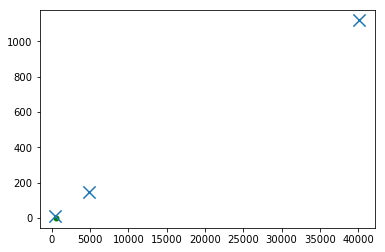

coordinate: [  0   0 500  14   1] label: 0


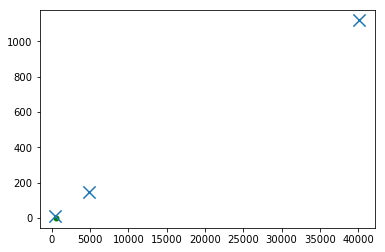

coordinate: [50  2 75 14  1] label: 0


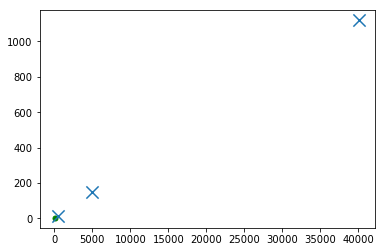

coordinate: [  0   0 500  14   1] label: 0


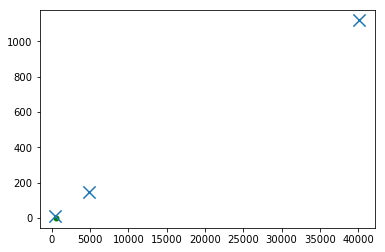

coordinate: [  0   0 400  13   1] label: 0


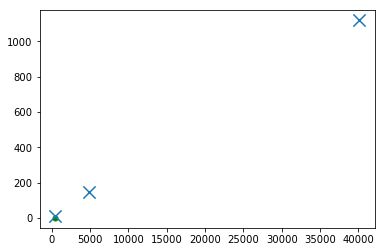

In [49]:
## Fit K-Means for the selected variables: 
## funded_amount, lender_count, loan_amount, terms.repayment_term, borrower_count
kmeans = KMeans(n_clusters = 3)
kmeans.fit(X)
centroid = kmeans.cluster_centers_
labels = kmeans.labels_
colors = ["g.","r.","c."]

## Plot the results
for i in range(5):
    print ("coordinate:", X[i], "label:", labels[i])
    plt.plot(X[i][2],X[i][1],colors[labels[i]],markersize=10)
    plt.scatter(centroid[:,0],centroid[:,1], marker = "x", s=150, linewidths = 5, zorder =10)
    plt.show()

# Step 3: Validating Our Cluster Analysis

Let's break down step by step what the above chunk of code is actually doing and assess some of the factors worth considering as you form a cluster analysis.

# Determining k

In [50]:
## Define the number of clusters you want
kmeans = KMeans(n_clusters=3)

All this line of code does is arbitrarily set the number of clusters to 3. But determining the appropriate number of clusters (k) is actually one of the most challenging parts of cluster analysis. Because the number of clusters will always vary depending on your data and what you are trying to assess, there is no hard and fast rule for what the value of k should be. 

<b>Why does determining k matter? Is it possible to have too many clusters? Or too few clusters?</b>

The number of groups you choose to partition in your data directly influences the results you produce. In most areas of data analysis, it's attractive to take as granular an approach as possible, but having too many clusters can be counterproductive. Consider these extreme examples: 

1. Treating each data point as its own cluster
2. Treating all your data points as one cluster

Neither of these will tell you anything new about your data! Rather, clustering is most effective when observations in the same cluster are very similar to each other. Relatedly, we want observations in different clusters to be as different from each other as possible.

<b>So how can I validate my choice of k?</b>

There are many statistical methods proposed to help determine k, including <b><a href="http://cs.fit.edu/~pkc/papers/ictai04salvador.pdf">the elbow method</a></b>, <b><a href="https://cs.fit.edu/~pkc/classes/ml-internet/silhouette.pdf">the silhouette method</a></b>, the information criterion approach, cross validation, and more. 

The <b>elbow method</b> is a simple, intuitive check. What the elbow method does is this:

1. Run the k-means algorithm over your dataset for a range of values (<i>e.g.,</i> let k be between 1 and 10 inclusive)
2. For each value of k, calculate the sum of squared errors (SSE)

Check out a Python implementation of the elbow method on the Kiva data below:

In [51]:
## Elbow method code here

## Plot of elbow method results here

<b>Limitations of the Elbow Method</b>

The elbow method makes sense to use when your data is actually reasonably clustered. But it's possible that your data may not be very clustered. For example, if we see a smooth curve rather than a sharply-defined "elbow" in the plot above, then it's not obvious what the optimal vaue of k is.

<b>The Silhouette Method</b>

The <b>Silhouette Coefficient</b> (also known as "Silhouette Score") is a measure of how well samples are clustered with samples that are similar to themselves. Clustering models with a high Silhouette Coefficient are "dense" (samples in the same cluster are similar to each other) and "well separated" (samples in different clusters are not very similar to each other). High Silhouette Coefficients are desirable.

<b>Calculating the Silhouette Coefficient</b>

The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. Mathematically, the Silhouette Coefficient for a sample is <b>(b - a) / max(a, b)</b>, where b is the distance between a sample and the nearest cluster that the sample is not a part of. 

The best value for a Silhouette Coefficient to take on is 1 and the worst is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

Check out the code below for an implementation of the silhouette method on a sample of the Kiva data:

For n_clusters = 2 The average silhouette_score is : 0.974663577713


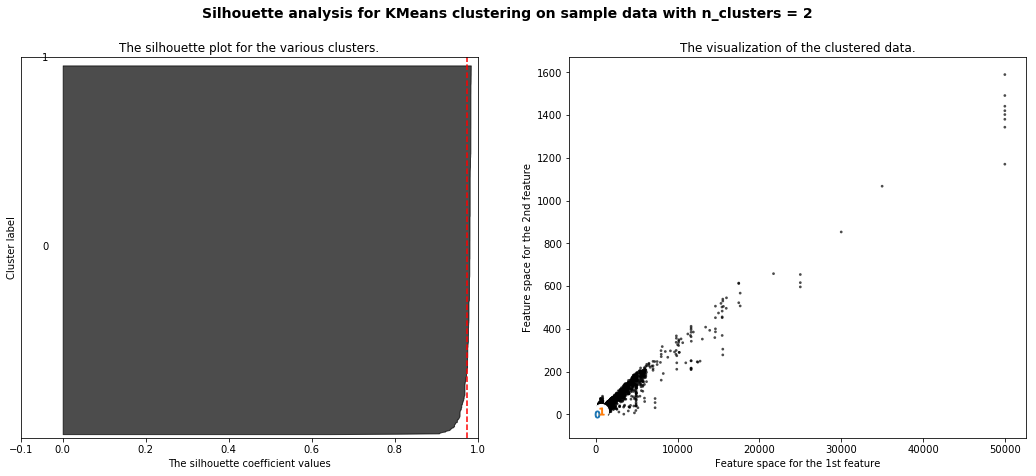

For n_clusters = 3 The average silhouette_score is : 0.540703665012


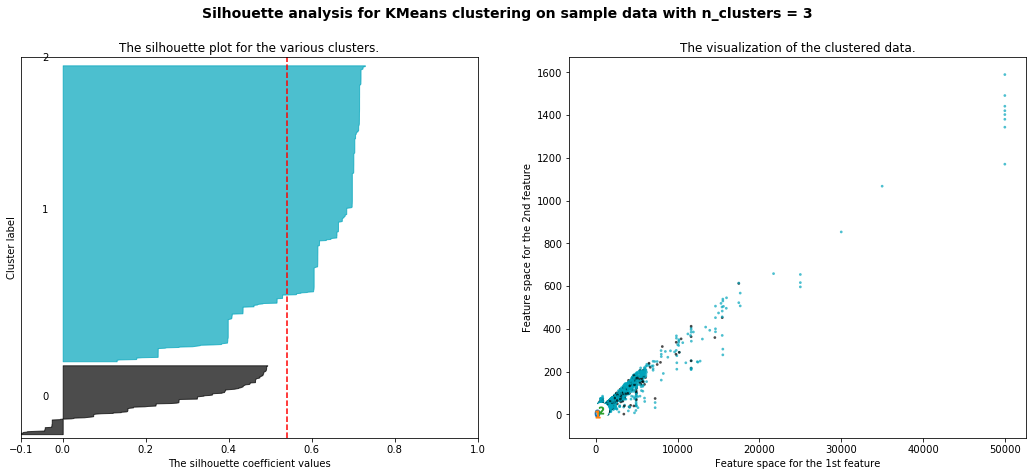

For n_clusters = 4 The average silhouette_score is : 0.507172193246


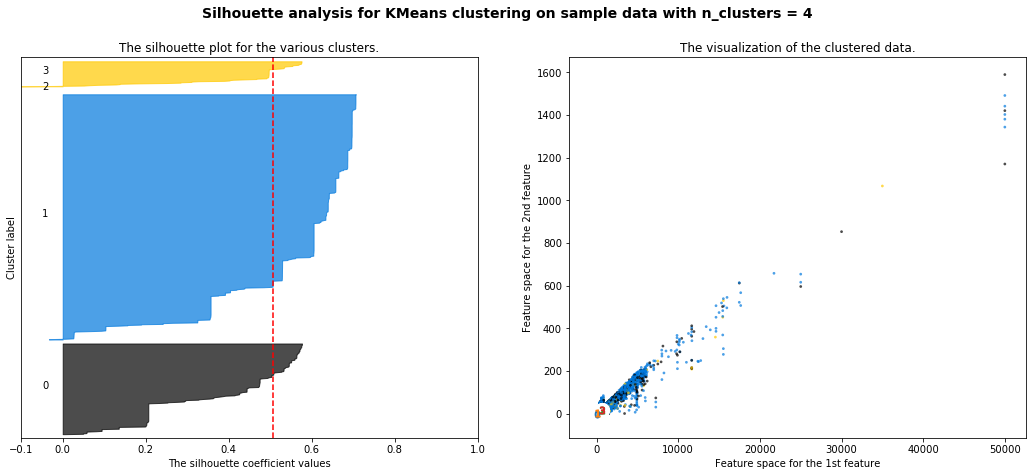

For n_clusters = 5 The average silhouette_score is : 0.494707918955


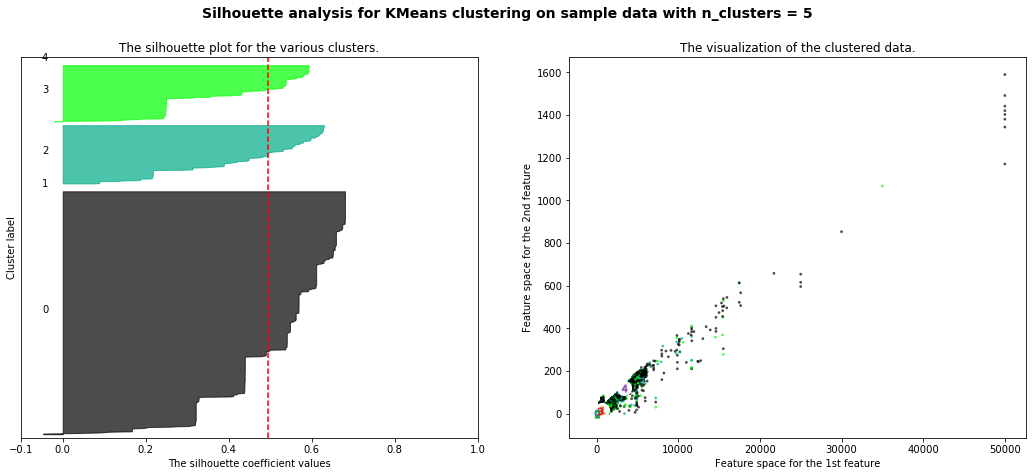

For n_clusters = 6 The average silhouette_score is : 0.489636503039


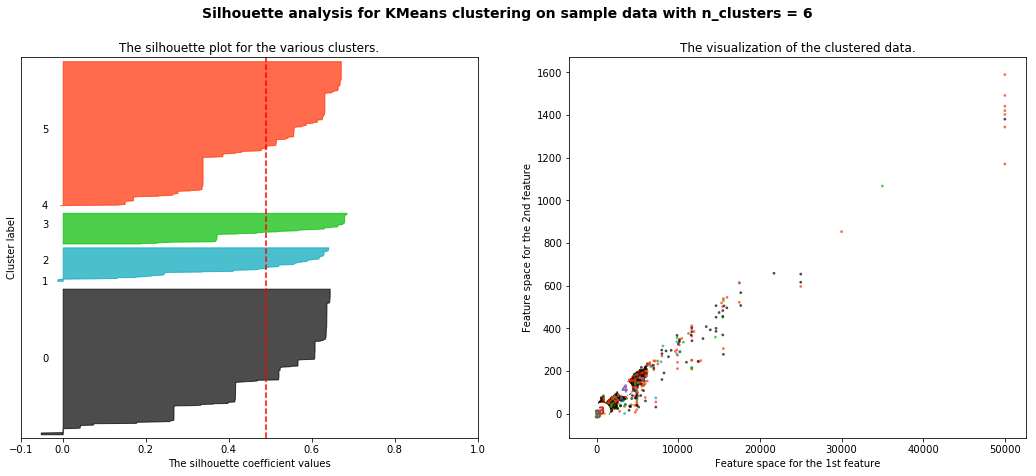

In [52]:
## Silhouette method

## Use a sample of the data, full dataset is too much for a small machine
X_sil = X[1:1000,0:5]

## Number of clusters to check
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_sil) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_sil)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_sil, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_sil, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

In this case, the Silhouette Coefficient is the mean across all the samples. As we see from the plots above, the Silhouette Coefficient is closest to 1.0 when n_clusters = 2. When there are only two clusters, we see that the points are closer within their clusters than to other clusters. 

Now that we have a better understanding of an appropriate value for k, let's update our n_clusters assignment:

In [53]:
## Define the number of clusters you want
kmeans = KMeans(n_clusters=2)

While manually calculating the k-means algorithm is exhaustive, we see that using the sklearn package is simple:

In [54]:
## Fitting the data
## Recall that X is defined above as an array of features:
## funded_amount, lender_count, loan_amount, terms.repayment_term, borrower_count
kmeans.fit(X)

## Set the initial, random center points
centroid = kmeans.cluster_centers_

Let's re-evaluate the updated plot and see what we can glean from it.

coordinate: [  0   0 500  14   1] label: 0


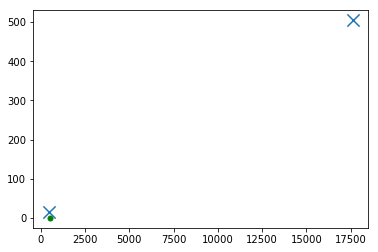

coordinate: [  0   0 500  14   1] label: 0


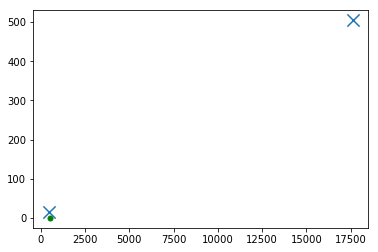

coordinate: [50  2 75 14  1] label: 0


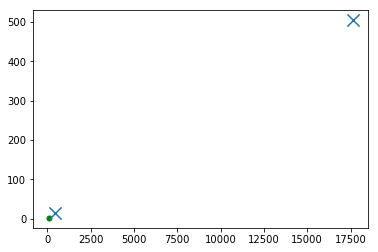

coordinate: [  0   0 500  14   1] label: 0


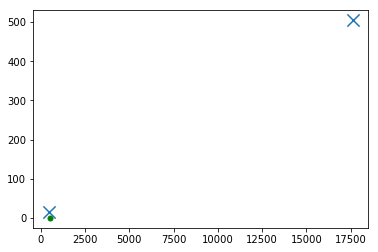

coordinate: [  0   0 400  13   1] label: 0


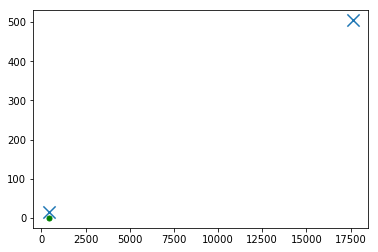

In [56]:
labels = kmeans.labels_
colors = ["g.","r.","c."]

## Plot the results
for i in range(5):
    print ("coordinate:", X[i], "label:", labels[i])
    plt.plot(X[i][2],X[i][1],colors[labels[i]],markersize=10)
    plt.scatter(centroid[:,0],centroid[:,1], marker = "x", s=150, linewidths = 5, zorder =10)
    plt.show()

We can see that loans generally fall into two categories:



In [49]:
## Placeholder - summary stats/plots of cluster-groups